# Setup

---

The idea for the following project came from a [Medium post](https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8). We improve the Medium's code adding new models and new analysis. To do that, the group used as tools the [ChatGPT](https://chat.openai.com/) optimizations and the [Aurélien Geron's public notebooks](https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb)


In [1]:
import datetime as dt
import time as tm

# AI
import keras

# Graphics library
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Data preparation
from yahoo_fin import stock_info as yf

from utils import (
    last_time_step_mse,
    plot_learning_curves,
    plot_multiple_forecasts,
    plot_series,
)

## Data

--- 

#### Load Data From Yahoo API

In [2]:
tf.random.set_seed(42)

ANALYZED_YEARS = 5
STOCK = "GOOGL"
INTERVAL = "1d"
N_STEPS = 22  # working days of a month
EPOCHS = 50

In [3]:
init_df = yf.get_data(
    STOCK,
    start_date=(dt.date.today() - dt.timedelta(days=365 * ANALYZED_YEARS)).strftime(
        "%Y-%m-%d"
    ),
    end_date=tm.strftime("%Y-%m-%d"),
    interval=INTERVAL,
)
init_df.to_csv(f"./data/raw/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}.csv")
init_df.head()

,open,high,low,close,adjclose,volume,ticker
2018-06-12,57.050999,57.437500,57.050999,57.409500,57.409500,26092000,GOOGL
2018-06-13,57.613998,57.782001,57.168999,57.211498,57.211498,34302000,GOOGL
2018-06-14,57.610500,58.299500,57.529999,58.005501,58.005501,35422000,GOOGL
2018-06-15,57.995998,58.195499,57.684502,57.963501,57.963501,44438000,GOOGL
2018-06-18,57.634499,59.206501,57.549999,59.179001,59.179001,33038000,GOOGL


In [4]:
# remove unused columns
init_df.drop(
    ["open", "high", "low", "adjclose", "ticker", "volume"], axis=1, inplace=True
)
init_df["date"] = init_df.index
init_df.reset_index(drop=True, inplace=True)

# Scale
scaler = MinMaxScaler()
init_df["close_norm"] = scaler.fit_transform(
    np.expand_dims(init_df["close"].values, axis=1)
)
init_df.to_csv(f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}.csv")

# Save scaled array
np.save(
    f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}_norm", init_df["close_norm"]
)

init_df.head()


,close,date,close_norm
0,57.409500,2018-06-12,0.081268
1,57.211498,2018-06-13,0.079300
2,58.005501,2018-06-14,0.087192
3,57.963501,2018-06-15,0.086775
4,59.179001,2018-06-18,0.098857


#### Visualization 

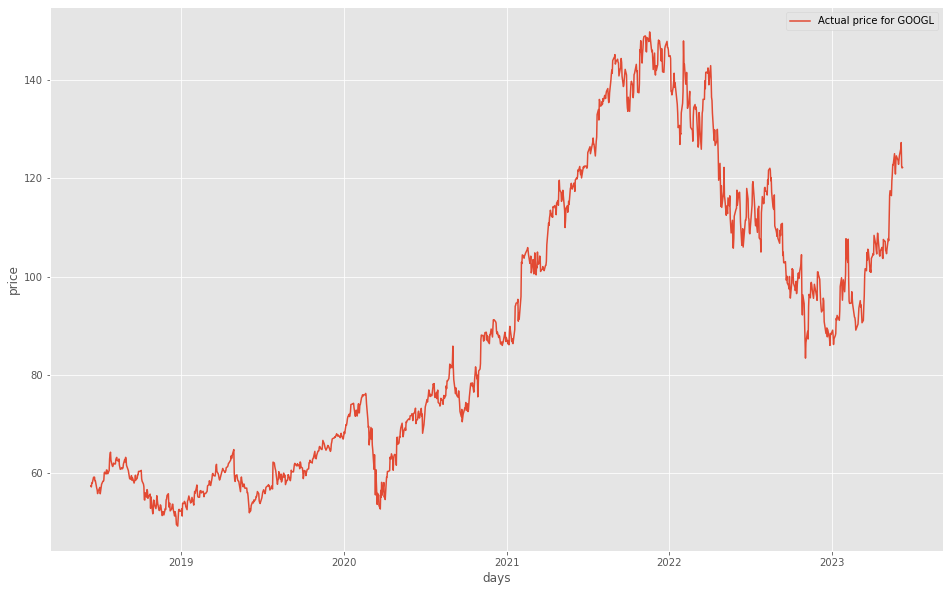

In [5]:
plt.style.use(style="ggplot")
plt.figure(figsize=(16, 10))
plt.plot(init_df["date"], init_df["close"])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f"Actual price for {STOCK}"])
plt.show()

#### Data split

In [6]:
data = np.load(f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}_norm.npy")

data = np.reshape(data[data.size % N_STEPS :], (data.size // N_STEPS, N_STEPS, 1))

X_train, y_train = (
    data[: int(data.shape[0] * 0.8), : N_STEPS - 1],
    data[: int(data.shape[0] * 0.8), -1],
)
X_test, y_test = (
    data[int(data.shape[0] * 0.8):, : N_STEPS - 1],
    data[int(data.shape[0] * 0.8):, -1],
)

## Models

---

#### Naive Forecasting

In [7]:
y_pred = X_test[:, -1]
np.mean(keras.losses.mean_squared_error(y_pred, y_test))

0.0007817448174369111

#### Linear Regression

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=[N_STEPS - 1, 1]), keras.layers.Dense(1)]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))
model.save(f"./models/LR_{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}-{N_STEPS}timeSteps")

Epoch 1/50
2/2 [==============================] - 1s 136ms/step - loss: 0.0746 - val_loss: 0.1027
Epoch 2/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0631 - val_loss: 0.0878
Epoch 3/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0528 - val_loss: 0.0741
Epoch 4/50
2/2 [==============================] - 0s 23ms/step - loss: 0.0439 - val_loss: 0.0618
Epoch 5/50
2/2 [==============================] - 0s 24ms/step - loss: 0.0353 - val_loss: 0.0510
Epoch 6/50
2/2 [==============================] - 0s 34ms/step - loss: 0.0282 - val_loss: 0.0415
Epoch 7/50
2/2 [==============================] - 0s 41ms/step - loss: 0.0223 - val_loss: 0.0334
Epoch 8/50
2/2 [==============================] - 0s 35ms/step - loss: 0.0174 - val_loss: 0.0266
Epoch 9/50
2/2 [==============================] - 0s 27ms/step - loss: 0.0129 - val_loss: 0.0211
Epoch 10/50
2/2 [==============================] - 0s 26ms/step - loss: 0.0095 - val_loss: 0.0167
Epoch 11/50
2/2 [===========

INFO:tensorflow:Assets written to: ./models/LR_GOOGL_5Y_1d-22timeSteps\assets


INFO:tensorflow:Assets written to: ./models/LR_GOOGL_5Y_1d-22timeSteps\assets


1/1 [==============================] - 0s 21ms/step - loss: 0.0058


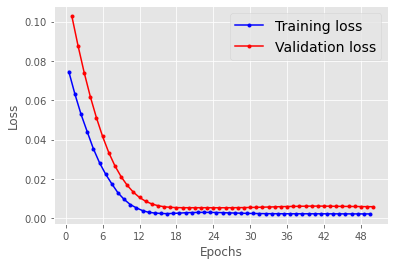

In [9]:
model.evaluate(X_test, y_test)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 0s 78ms/step


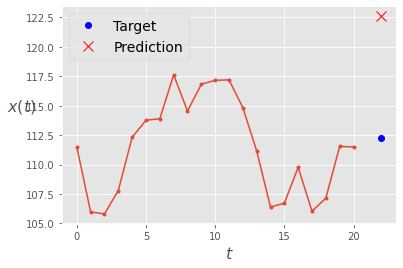

In [10]:
y_pred = model.predict(X_test)
plot_series(scaler.inverse_transform([X_test[0, :,0]])[0], scaler.inverse_transform(np.array([[y_test[0,0]]])), scaler.inverse_transform(np.array([[y_pred[0,0]]])), n_steps=N_STEPS)
plt.show()

#### Deep RNN

In [11]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1),
    ]
)

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))
model.save(f"./models/RNN_{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}-{N_STEPS}timeSteps")


Epoch 1/50
2/2 [==============================] - 2s 431ms/step - loss: 0.9328 - val_loss: 0.7371
Epoch 2/50
2/2 [==============================] - 0s 32ms/step - loss: 0.4850 - val_loss: 0.2956
Epoch 3/50
2/2 [==============================] - 0s 37ms/step - loss: 0.2604 - val_loss: 0.0707
Epoch 4/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1711 - val_loss: 0.0169
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 0.1441 - val_loss: 0.0123
Epoch 6/50
2/2 [==============================] - 0s 33ms/step - loss: 0.1374 - val_loss: 0.0130
Epoch 7/50
2/2 [==============================] - 0s 33ms/step - loss: 0.1202 - val_loss: 0.0114
Epoch 8/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0952 - val_loss: 0.0085
Epoch 9/50
2/2 [==============================] - 0s 30ms/step - loss: 0.0691 - val_loss: 0.0073
Epoch 10/50
2/2 [==============================] - 0s 32ms/step - loss: 0.0451 - val_loss: 0.0088
Epoch 11/50
2/2 [===========

INFO:tensorflow:Assets written to: ./models/RNN_GOOGL_5Y_1d-22timeSteps\assets


INFO:tensorflow:Assets written to: ./models/RNN_GOOGL_5Y_1d-22timeSteps\assets


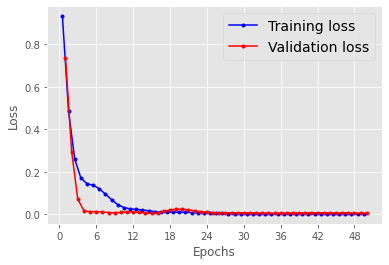

In [12]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

1/1 [==============================] - 0s 181ms/step


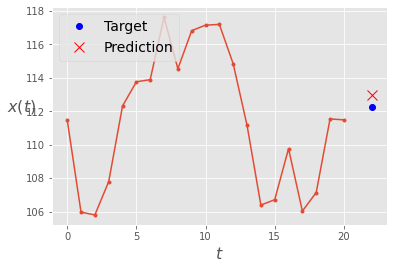

In [13]:
y_pred = model.predict(X_test)
plot_series(scaler.inverse_transform([X_test[0, :,0]])[0], scaler.inverse_transform(np.array([[y_test[0,0]]])), scaler.inverse_transform(np.array([[y_pred[0,0]]])), n_steps=N_STEPS)
plt.show()

### Forecast several time steps ahead

---

To forecast several time steps ahead, we need a new manipulation data method and robust models with memory cells. Here we can establish a comparison between a LSTM and a GRU model.

In [14]:
N_STEPS = 30
FORECAST_DAYS = 5

data = np.load(f"./data/processed/{STOCK}_{ANALYZED_YEARS}Y_{INTERVAL}_norm.npy")
data = np.reshape(data[data.size % N_STEPS :], (data.size // N_STEPS, N_STEPS, 1))

X_train = data[: int(data.shape[0] * 0.8), : N_STEPS - FORECAST_DAYS]
X_test = data[int(data.shape[0] * 0.8) :, : N_STEPS - FORECAST_DAYS]

Y = np.empty((data.shape[0], N_STEPS - FORECAST_DAYS, FORECAST_DAYS))
for step_ahead in range(1, FORECAST_DAYS + 1):
    Y[:, :, step_ahead - 1] = data[
        :, step_ahead : step_ahead + N_STEPS - FORECAST_DAYS, 0
    ]

y_train = Y[: int(data.shape[0] * 0.8)]
y_test = Y[int(data.shape[0] * 0.8) :]


#### LSTMs

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential(
    [
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(FORECAST_DAYS)),
    ]
)

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test))


Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 0.2503 - last_time_step_mse: 0.2691 - val_loss: 0.3110 - val_last_time_step_mse: 0.3168
Epoch 2/50
1/1 [==============================] - 0s 48ms/step - loss: 0.2404 - last_time_step_mse: 0.2547 - val_loss: 0.2980 - val_last_time_step_mse: 0.2986
Epoch 3/50
1/1 [==============================] - 0s 45ms/step - loss: 0.2309 - last_time_step_mse: 0.2411 - val_loss: 0.2857 - val_last_time_step_mse: 0.2815
Epoch 4/50
1/1 [==============================] - 0s 52ms/step - loss: 0.2219 - last_time_step_mse: 0.2283 - val_loss: 0.2739 - val_last_time_step_mse: 0.2653
Epoch 5/50
1/1 [==============================] - 0s 41ms/step - loss: 0.2132 - last_time_step_mse: 0.2162 - val_loss: 0.2625 - val_last_time_step_mse: 0.2498
Epoch 6/50
1/1 [==============================] - 0s 43ms/step - loss: 0.2049 - last_time_step_mse: 0.2047 - val_loss: 0.2515 - val_last_time_step_mse: 0.2349
Epoch 7/50
1/1 [==============================] 

1/1 [==============================] - 0s 24ms/step - loss: 0.0485 - last_time_step_mse: 0.0151


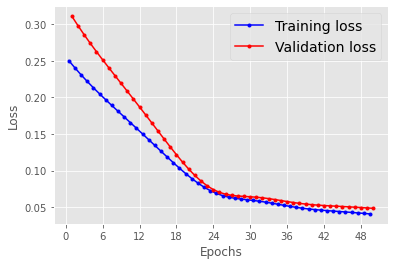

In [16]:
model.evaluate(X_test, y_test)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

2/2 [==============================] - 1s 6ms/step


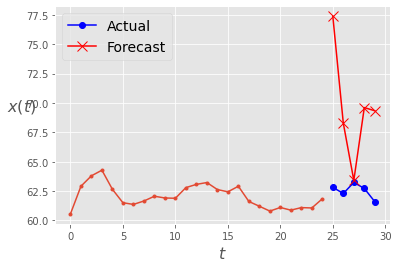

In [17]:
np.random.seed(43)
X_new, Y_new = (
    data[:, : N_STEPS - FORECAST_DAYS, :],
    data[:, N_STEPS - FORECAST_DAYS :, :],
)
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred, scaler)
plt.show()
